In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Layer, Bidirectional, Attention
from keras import optimizers 
from sklearn.metrics import mean_squared_error

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_raw = pd.read_csv("VNM.csv", index_col="Date", parse_dates=["Date"])
data_raw = data_raw.dropna()

 Count row of data:  988


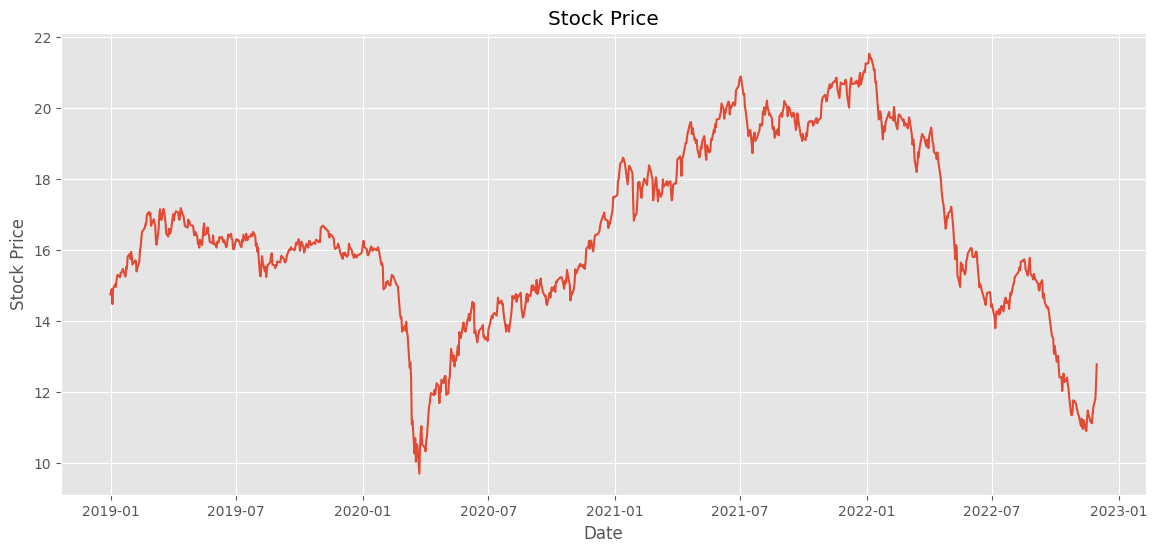

In [3]:
dataset = pd.DataFrame(data_raw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Stock Price')
plt.show()

In [4]:
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2018-12-31,0.426881
2019-01-02,0.439560
2019-01-03,0.404057
2019-01-04,0.440406
2019-01-07,0.451395
...,...
2022-11-23,0.120034
2022-11-25,0.158073
2022-11-28,0.177515


In [5]:
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.75)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.15)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

In [6]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [7]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=64
epoch = 100

# Architecture Gated Recurrent Unit
model = Sequential()

# First GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'relu')))
model.add(Dropout(0.2))
# Second GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=True, activation = 'relu')))
model.add(Dropout(0.2))
# Third GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=False, activation = 'relu')))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Epoch 1/100
12/12 [==============================] - 7s 74ms/step - loss: 0.3323 - val_loss: 0.5544
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2040 - val_loss: 0.2234
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0391 - val_loss: 0.0065
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0226 - val_loss: 0.0511
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0178 - val_loss: 0.0116
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0154
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0066 - val_loss: 0.0010
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0045 - val_loss: 6.7726e-04
Epoch 10/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0042 - val_loss: 7.

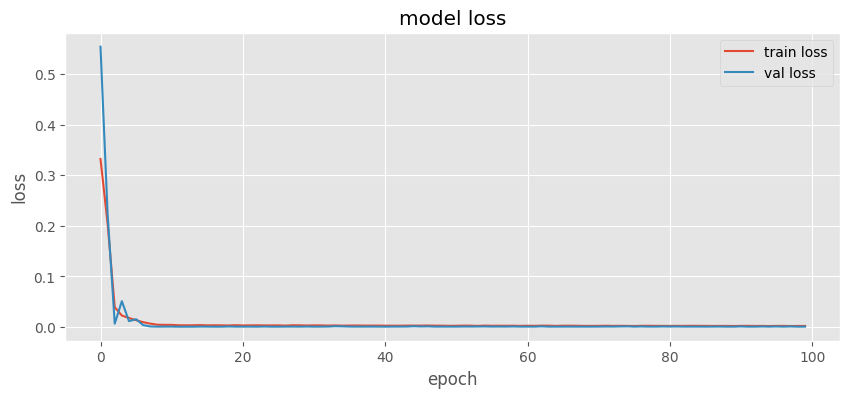

In [8]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [9]:
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.00208,0.000719


In [10]:
y_pred_test = model.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

5/5 [==============================] - 1s 3ms/step


In [11]:
set_test = dataset["Close"]

In [12]:
datacompare = pd.DataFrame()
datatest=np.array(set_test[totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,17.219999,16.975758
1,17.059999,17.070501
2,16.860001,17.027273
3,16.620001,16.844774
4,15.740000,16.623411
...,...,...
142,11.120000,10.914590
143,11.570000,10.896721
144,11.800000,11.119532
145,12.200000,11.494560


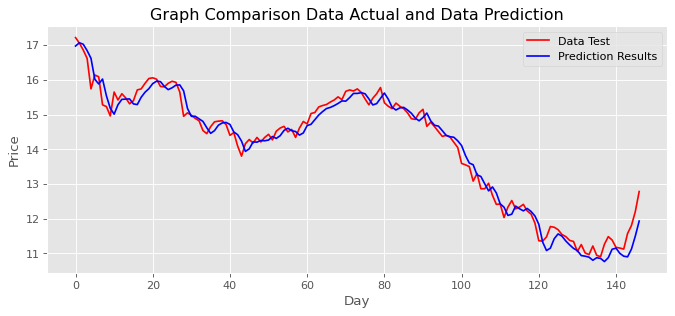

In [13]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
def MAPE(datatest,datapred):
    mape = np.mean(np.abs((datatest - datapred)/datatest))*100
    return mape

mape = MAPE(datatest, datapred)
print(mape)

13.690183084048444


In [15]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(datatest, datapred)
RMSE = math.sqrt(MSE)
print(RMSE)

0.2758495722938143


In [16]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_true=datatest,
    y_pred=datapred
)

0.21004672053247572